# Introduction

# Setup
Let us import the required modules.

In [12]:
import pandas as pd
import seaborn as sns
import os
import joblib

import src.data_split as ds
import src.evaluation as eva

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

## Load Data
Note that the dataset is already split into Train-Test sets.

In [13]:
data_split = ds.TrainTestSplit.from_csv_directory(dir_path="../data")

In [14]:
data_split.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

In [15]:
data_split.y_train.shape

(60000,)

# Support Vector Machine Classifier Model

Use a smaller dataset due to the workload of GridSearchCV on SVC

In [21]:
whole_data = data_split.x_train.copy()

In [23]:
whole_data["Number"] = data_split.y_train

In [24]:
data_split.x_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

In [33]:
whole_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 720 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64
 3

<AxesSubplot:xlabel='Number', ylabel='count'>

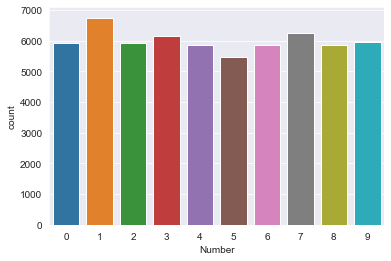

In [26]:
sns.countplot(x=whole_data["Number"])

In [29]:
data_small = whole_data.groupby('Number', group_keys=False).apply(lambda x: x.sample(200))
data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2913 to 35647
Data columns (total 720 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64


<AxesSubplot:xlabel='Number', ylabel='count'>

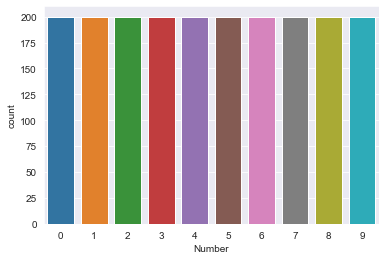

In [30]:
sns.countplot(x=data_small["Number"])

In [34]:
y_data_small = data_small["Number"].copy()
x_data_small = data_small.drop(columns=['Number'])

In [39]:
x_data_small.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 2913 to 35647
Data columns (total 719 columns):
 #    Column    Dtype  
---   ------    -----  
 0    pixel13   float64
 1    pixel14   float64
 2    pixel15   float64
 3    pixel16   float64
 4    pixel33   float64
 5    pixel34   float64
 6    pixel35   float64
 7    pixel36   float64
 8    pixel37   float64
 9    pixel38   float64
 10   pixel39   float64
 11   pixel40   float64
 12   pixel41   float64
 13   pixel42   float64
 14   pixel43   float64
 15   pixel44   float64
 16   pixel45   float64
 17   pixel46   float64
 18   pixel47   float64
 19   pixel48   float64
 20   pixel49   float64
 21   pixel50   float64
 22   pixel51   float64
 23   pixel52   float64
 24   pixel59   float64
 25   pixel60   float64
 26   pixel61   float64
 27   pixel62   float64
 28   pixel63   float64
 29   pixel64   float64
 30   pixel65   float64
 31   pixel66   float64
 32   pixel67   float64
 33   pixel68   float64
 34   pixel69   float64


In [38]:
y_data_small.shape

(2000,)

In [40]:
# x_data_small.to_csv('../data/x_small.csv',index=False)
# y_data_small.to_csv('../data/y_small.csv',index=False)

## SVM  using Linear kernel
LinearSVC is another (faster) implementation of Support Vector Classification for the case of a linear kernel

In [ ]:
import time

# automatic parameters tuning
svcclsf_lin=SVC(random_state=28)
properties={
    "n_estimators": [x for x in range(50,201,50)],
    "min_samples_leaf": [x for x in range(50,201,50)],
    "max_leaf_nodes": [x for x in range(75,176,25)]
}

start_time = time.time()
tuned_svcclsf_lin=GridSearchCV(svcclsf_lin,properties,scoring="accuracy",cv=10,return_train_score=True,verbose=6,n_jobs=4)
tuned_svcclsf_lin.fit(data_split.x_train,data_split.y_train)
print("--- %s seconds ---" % (time.time() - start_time))

print ("Best Score: {:.3f}".format(tuned_svcclsf_lin.best_score_) )
print ("Best Params: ", tuned_svcclsf_lin.best_params_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits


In [40]:
# save results
if not os.path.exists('../tuned_models'):
    os.mkdir('../tuned_models')
joblib.dump(tuned_svcclsf_lin, '../tuned_models/svc_linear_tuning_results.pkl')

['../tuned_models/randforest_tuning_results.pkl']

In [51]:
# to load previously saved results
tuned_svcclsf_lin = joblib.load("../tuned_models/svc_linear_tuning_results.pkl")

In [52]:
print(tuned_svcclsf_lin.cv_results_)
tuned_svcclsf_lin_results = pd.DataFrame( tuned_svcclsf_lin.cv_results_ )

{'mean_fit_time': array([15.997925  , 23.03155446, 23.56815186, 27.78082929,  7.78263092,
       15.17835119, 21.5160517 , 28.77120373,  7.61016257, 14.03604698,
       20.91096237, 33.56151788,  9.13062282, 15.23432872, 19.18838079,
       25.18457246,  6.82220395, 12.67001328, 19.26948206, 25.85195463,
        9.55779963, 17.57098837, 25.04154773, 32.27769506,  8.75613511,
       16.61888962, 24.66099069, 36.50186636,  9.19590235, 15.89663391,
       23.22585144, 30.54554975,  8.47385738, 14.82109668, 21.62094781,
       28.95282202,  8.03952277, 15.28052816, 22.33927765, 28.44294915,
        8.82855427, 16.60645597, 24.68460464, 33.3292325 ,  8.94557321,
       17.77358584, 25.34087112, 32.72111297,  8.55460277, 16.64532712,
       24.31343064, 33.29507117,  9.18621914, 17.47464902, 24.34679081,
       32.17171738,  8.46703269, 16.34600215, 24.3422323 , 34.57345903,
       12.3649236 , 22.49158566, 31.09011328, 40.92023115, 10.60617757,
       20.69091232, 31.59060011, 41.91015129, 

In [53]:
tuned_svcclsf_lin_results[["param_n_estimators","mean_test_score","mean_train_score"]]

,param_n_estimators,mean_test_score,mean_train_score
0,50,0.763267,0.764993
1,100,0.774950,0.775820
2,150,0.781617,0.782530
3,200,0.782067,0.782774
4,50,0.763267,0.764993
...,...,...,...
95,200,0.889500,0.893252
96,50,0.881650,0.884185
97,100,0.886267,0.889620
98,150,0.889167,0.891993


<AxesSubplot:xlabel='param_n_estimators', ylabel='mean_test_score'>

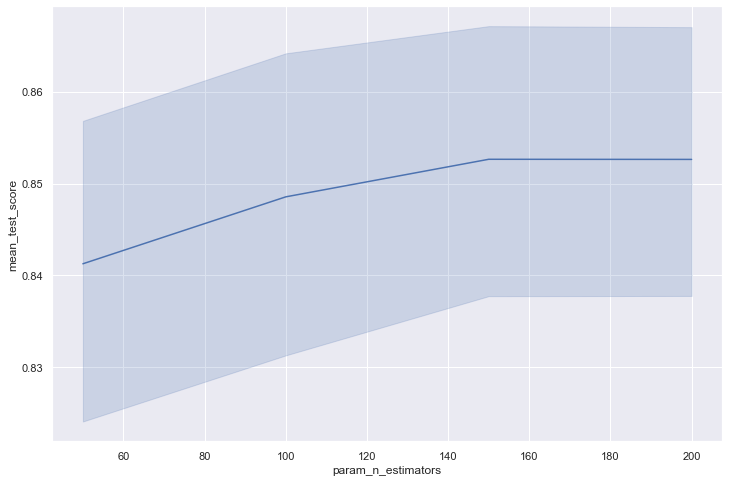

In [54]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_lin_results, x="param_n_estimators", y="mean_test_score")

In [55]:
print(tuned_svcclsf_lin.best_estimator_)
print(tuned_svcclsf_lin.best_score_)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=75, n_estimators=200,
                       random_state=28)
0.8904833333333334


In [56]:
test_acc = accuracy_score(y_true = data_split.y_train,
                          y_pred = tuned_svcclsf_lin.predict(data_split.x_train) )
print ("Train Accuracy: {}".format(test_acc) )

Train Accuracy: 0.8940833333333333


In [57]:
# best parameters from automatic parameters tuning
svc_lin_clsf = SVC(**tuned_svcclsf_lin.best_params_)
# svc_lin_clsf = SVC(max_leaf_nodes=100, min_samples_leaf=75, n_estimators=200, random_state=28)

svc_lin_clsf.fit(data_split.x_train, data_split.y_train)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=75, n_estimators=200)

In [58]:
svc_lin_train_pred = svc_lin_clsf.predict(data_split.x_train)
svc_lin_test_pred = svc_lin_clsf.predict(data_split.x_test)

svc_lin_train_eval = eva.Evaluation(y_real=data_split.y_train, y_pred=rf_train_pred)
svc_lin_test_eval = eva.Evaluation(y_real=data_split.y_test, y_pred=rf_test_pred)

In [59]:
print("Training:")
svc_lin_train_eval.print_eval()
print("Testing:")
svc_lin_test_eval.print_eval()

Training:
--------------Model Evaluations:--------------
Accuracy score: 0.8924666666666666

Testing:
--------------Model Evaluations:--------------
Accuracy score: 0.8881



In [52]:
# rf_model = eva.EvaluatedModel(forest_clsf, train_eval=svc_lin_train_eval, test_eval=rf_test_eval)

accuracy is not a great measure of classifier performance when the classes are imbalanced
but as we can see from the plots, the classes are more or less balanced

## SVM using Polynomial of degree 2 kernel

In [ ]:
import time

# automatic parameters tuning
svcclsf_pol=SVC(random_state=28)
properties={
    "n_estimators": [x for x in range(50,201,50)],
    "min_samples_leaf": [x for x in range(50,201,50)],
    "max_leaf_nodes": [x for x in range(75,176,25)]
}

start_time = time.time()
tuned_svcclsf_pol=GridSearchCV(svcclsf_pol,properties,scoring="accuracy",cv=10,return_train_score=True,verbose=6,n_jobs=4)
tuned_svcclsf_pol.fit(data_split.x_train,data_split.y_train)
print("--- %s seconds ---" % (time.time() - start_time))

print ("Best Score: {:.3f}".format(tuned_svcclsf_pol.best_score_) )
print ("Best Params: ", tuned_svcclsf_pol.best_params_)

In [ ]:
# save results
if not os.path.exists('../tuned_models'):
    os.mkdir('../tuned_models')
joblib.dump(tuned_svcclsf_pol, '../tuned_models/svc_polynomial_tuning_results.pkl')

In [ ]:
# to load previously saved results
tuned_svcclsf_pol = joblib.load("../tuned_models/svc_polynomial_tuning_results.pkl")

In [ ]:
print(tuned_svcclsf_pol.cv_results_)
tuned_svcclsf_pol_results = pd.DataFrame( tuned_svcclsf_pol.cv_results_ )

In [ ]:
tuned_svcclsf_pol_results[["param_n_estimators","mean_test_score","mean_train_score"]]

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_pol_results, x="param_n_estimators", y="mean_test_score")

In [ ]:
print(tuned_svcclsf_pol.best_estimator_)
print(tuned_svcclsf_pol.best_score_)

In [ ]:
test_acc = accuracy_score(y_true = data_split.y_train,
                          y_pred = tuned_svcclsf_pol.predict(data_split.x_train) )
print ("Train Accuracy: {}".format(test_acc) )

In [ ]:
# best parameters from automatic parameters tuning
svc_pol_clsf = SVC(**tuned_svcclsf_pol.best_params_)
# svc_pol_clsf = SVC(max_leaf_nodes=100, min_samples_leaf=75, n_estimators=200, random_state=28)

svc_pol_clsf.fit(data_split.x_train, data_split.y_train)

In [ ]:
svc_pol_train_pred = svc_pol_clsf.predict(data_split.x_train)
svc_pol_test_pred = svc_pol_clsf.predict(data_split.x_test)

svc_pol_train_eval = eva.Evaluation(y_real=data_split.y_train, y_pred=rf_train_pred)
svc_pol_test_eval = eva.Evaluation(y_real=data_split.y_test, y_pred=rf_test_pred)

In [ ]:
print("Training:")
svc_pol_train_eval.print_eval()
print("Testing:")
svc_pol_test_eval.print_eval()

## SVM  using  RBF kernel

In [ ]:
import time

# automatic parameters tuning
svcclsf_rbf=SVC(random_state=28)
properties={
    "n_estimators": [x for x in range(50,201,50)],
    "min_samples_leaf": [x for x in range(50,201,50)],
    "max_leaf_nodes": [x for x in range(75,176,25)]
}

start_time = time.time()
tuned_svcclsf_rbf=GridSearchCV(svcclsf_rbf,properties,scoring="accuracy",cv=10,return_train_score=True,verbose=6,n_jobs=4)
tuned_svcclsf_rbf.fit(data_split.x_train,data_split.y_train)
print("--- %s seconds ---" % (time.time() - start_time))

print ("Best Score: {:.3f}".format(tuned_svcclsf_rbf.best_score_) )
print ("Best Params: ", tuned_svcclsf_rbf.best_params_)

In [ ]:
# save results
if not os.path.exists('../tuned_models'):
    os.mkdir('../tuned_models')
joblib.dump(tuned_svcclsf_rbf, '../tuned_models/svc_rbf_tuning_results.pkl')

In [ ]:
# to load previously saved results
tuned_svcclsf_rbf = joblib.load("../tuned_models/svc_rbf_tuning_results.pkl")

In [ ]:
print(tuned_svcclsf_rbf.cv_results_)
tuned_svcclsf_rbf_results = pd.DataFrame( tuned_svcclsf_rbf.cv_results_ )

In [ ]:
tuned_svcclsf_rbf_results[["param_n_estimators","mean_test_score","mean_train_score"]]

In [ ]:
sns.set(rc={"figure.figsize":(12, 8)})
sns.lineplot(data=tuned_svcclsf_rbf_results, x="param_n_estimators", y="mean_test_score")

In [ ]:
print(tuned_svcclsf_rbf.best_estimator_)
print(tuned_svcclsf_rbf.best_score_)

In [ ]:
test_acc = accuracy_score(y_true = data_split.y_train,
                          y_pred = tuned_svcclsf_rbf.predict(data_split.x_train) )
print ("Train Accuracy: {}".format(test_acc) )

In [ ]:
# best parameters from automatic parameters tuning
svc_rbf_clsf = SVC(**tuned_svcclsf_rbf.best_params_)
# svc_rbf_clsf = SVC(max_leaf_nodes=100, min_samples_leaf=75, n_estimators=200, random_state=28)

svc_rbf_clsf.fit(data_split.x_train, data_split.y_train)

In [ ]:
svc_rbf_train_pred = svc_rbf_clsf.predict(data_split.x_train)
svc_rbf_test_pred = svc_rbf_clsf.predict(data_split.x_test)

svc_rbf_train_eval = eva.Evaluation(y_real=data_split.y_train, y_pred=rf_train_pred)
svc_rbf_test_eval = eva.Evaluation(y_real=data_split.y_test, y_pred=rf_test_pred)

In [ ]:
print("Training:")
svc_rbf_train_eval.print_eval()
print("Testing:")
svc_rbf_test_eval.print_eval()

# Performance Visualization

### Setup